In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [3]:
import torch

# If there's a GPU available...

if torch.cuda.is_available():    
    device = torch.device('cuda')    
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [4]:
from IPython.display import display, set_matplotlib_formats
from collections import Counter
from itertools import chain
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
! pip install transformers
from transformers import AdamW, XLNetTokenizer, XLNetModel, TFXLNetModel, XLNetLMHeadModel, XLNetConfig, XLNetForSequenceClassification
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from tqdm import tqdm, trange
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, SpatialDropout1D, Activation, MaxPool2D, concatenate 
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
import gensim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import GRU, LSTM
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.nn import BCEWithLogitsLoss, NLLLoss
import warnings
import nltk
import torch
set_matplotlib_formats('svg')
warnings.filterwarnings('ignore')
nltk.download('punkt')

import os

     |████████████████████████████████| 3.1 MB 5.2 MB/s 
     |████████████████████████████████| 3.3 MB 29.9 MB/s 
     |████████████████████████████████| 596 kB 37.9 MB/s 
     |████████████████████████████████| 59 kB 6.6 MB/s 
     |████████████████████████████████| 895 kB 51.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
import string
import nltk
from nltk.stem import WordNetLemmatizer
import string
from nltk import word_tokenize
nltk.download('wordnet')
nltk.download('stopwords')
stop = stopwords.words('english')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
stop_words = stopwords.words('english')
addition = ['•', '!', '"', '#', '”', '“', '$', '%', '&', "'", '–', '(', ')', '*','’', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '…']
stop_words.extend(addition)

In [7]:
data=pd.read_csv('/content/drive/MyDrive/NLP/Reviews.csv')

In [8]:
data.dropna(how='any',inplace=True)
data.drop_duplicates(inplace=True, subset=['Score','Text'])
idx = data[data["HelpfulnessNumerator"]>data["HelpfulnessDenominator"]].index
data.drop(index=idx, inplace=True)

In [9]:
data.loc[data['Score'] <=2, 'Score'] = 0
data.loc[data['Score'] > 3, 'Score'] = 2
data.loc[data['Score'] == 3, 'Score'] = 1

In [10]:
neutral = data.loc[data.Score == 1]
positive = data.loc[data.Score == 2].sample(40000)
negative = data.loc[data.Score == 0].sample(40000)
data = pd.concat([positive, negative, neutral])

In [11]:
data['len'] = data.Text.apply(lambda x: len(x.split()))

In [12]:
data['len'].median()

61.0

In [13]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = text.translate(str.maketrans('', '', string.punctuation))
    result = ''.join([i for i in text if not i.isdigit()])
    tweet_tokens = nltk.word_tokenize(result)
    filtered_words = [w for w in tweet_tokens if not w in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in filtered_words]
    lemma_words=" ".join(lemma_words)
    return lemma_words

In [14]:
data['cleaned'] = data['Text'].apply(preprocess)

In [15]:
data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,len,cleaned
307555,307556,B0000DG86W,A2RXBCKO8MAP6U,Collette,0,0,2,1326412800,I love it!,This is an adorable bonsai- the last one I got...,34,adorable bonsai last one got amazon didnt well...
472817,472818,B000F4D5GC,A1XT0CDV8C97PF,nicelady,2,2,2,1339200000,Love this product because it is organic and un...,So very glad that Amazon.com sells Let's Do Or...,42,glad amazoncom sells lets organic shredded uns...
314288,314289,B008MUJAYC,AQQLWCMRNDFGI,Steven A. Peterson,2,3,2,1221955200,A good soy sauce,I use a lot of soy sauce in my kitchen. For on...,90,use lot soy sauce kitchen one thing make lot s...
338780,338781,B001SB1NFG,A3HON67T38XCB5,willy,0,0,2,1346457600,gravy,love gravy with my potatoes and bread. mix thi...,35,love gravy potatoes bread mix stuff quickly bu...
92415,92416,B007TGDXMK,A3BI4362EPTGBD,V. Salomon,1,1,2,1327968000,Hands Down The Best Bold K-Cup of Coffee!,"I stumbled across these on Amazon, and since I...",301,stumbled across amazon since looking cheap alt...
...,...,...,...,...,...,...,...,...,...,...,...,...
568336,568337,B001BOAOLY,A3CMHE6IJV79QM,Nancy J. Lumpkins,0,0,1,1285459200,Not Enough Lemon!,These taste basically as if there is no lemon ...,24,taste basically lemon honey slight aftertaste ...
568355,568356,B002XO3Q52,A7DMNT5YZ3JV1,RJT,0,0,1,1334534400,Paid too much,I paid well over labeled price and the produc...,44,paid well labeled price product fresh stamped ...
568369,568370,B000LKVRQA,A2ZX818P92CM7F,"Gregg Somers ""chillerdad""",1,2,1,1282694400,This is Earl Grey!???,"An admitted fan of Stash Earl Grey, neverthele...",121,admitted fan stash earl grey nevertheless ende...
568379,568380,B000H28ABW,A1XVKAMXSOW8ZV,"C. E. Hunsicker ""Hatshepsut""",2,3,1,1256515200,Just OK,I hadn't tried this taco seasoning prior to pu...,50,hadnt tried taco seasoning prior purchasing bu...


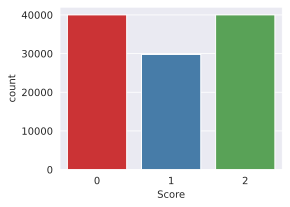

In [16]:
sns.set_style("darkgrid")
sns.set_palette('Set1')
fig, axes=plt.subplots(figsize=(4, 3))
axes = sns.countplot(data.Score)
fig.show()

In [17]:
maxlen = 100

corpus = [article.split() for article in data['cleaned']]
w2v_model = gensim.models.Word2Vec(sentences = corpus, size = 200, window = 1, min_count = 1)

text = [article.split() for article in data['cleaned']]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)
tokenized = tokenizer.texts_to_sequences(text)
word_index = tokenizer.word_index
print('Size of vocabulary: ', len(word_index))

tokenized_padded = pad_sequences(tokenized , maxlen=maxlen) #padding the sentences having size less than 100

Size of vocabulary:  102712


In [18]:
len(tokenized_padded)

109770

In [19]:
def create_embeddings(model, vocab): #here we will convert word2vec to keras weights
    size = len(vocab) + 1
    matrix = np.zeros((size, 200))
    for word, index in vocab.items():
        matrix[index] = model[word]
    return matrix

embedding_vectors = create_embeddings(w2v_model, word_index)

In [20]:
from tensorflow.keras.utils import to_categorical
y_cat = to_categorical(data['Score'])

In [21]:
X_train,X_test,y_train,y_test = train_test_split(tokenized_padded, y_cat, test_size=0.3, random_state=1000, stratify = y_cat)

In [22]:
max_len = 100
embed_size = 200
size = len(word_index) + 1

In [23]:
def build_model(lr = 0.0, lr_d = 0.0, units = 0, dr = 0.0):
    inp = Input(shape = (max_len,))
    x = Embedding(size, embed_size, weights = [embedding_vectors], trainable = False)(inp)
    x1 = SpatialDropout1D(dr)(x)

    x_cnn = Conv1D(filters=100, kernel_size=4, padding='same', activation='relu')(x1)
    x_cnn = BatchNormalization()(x1)
    x_cnn = MaxPooling1D(pool_size=2)(x1)
    x_cnn = SpatialDropout1D(0.25)(x1)
    x1 = Bidirectional(CuDNNLSTM(units, return_sequences = True))(x_cnn)
    avg_pool1_cnn = GlobalAveragePooling1D()(x1)
    max_pool1_cnn = GlobalMaxPooling1D()(x1)
    
    x_lstm = Bidirectional(CuDNNLSTM(units, return_sequences = True))(x1)
    x_lstm = BatchNormalization()(x1)
    x_lstm = MaxPooling1D(pool_size=2)(x1)
    x_lstm = SpatialDropout1D(0.25)(x1)
    x2 = Conv1D(32, kernel_size=3, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool1_lstm = GlobalAveragePooling1D()(x2)
    max_pool1_lstm = GlobalMaxPooling1D()(x2)
    
    
    x = concatenate([avg_pool1_cnn, max_pool1_cnn, avg_pool1_lstm, max_pool1_lstm])
    x = BatchNormalization()(x)
    x = Dropout(0.2)(Dense(128,activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(0.2)(Dense(100,activation='relu') (x))
    x = Dense(3, activation = "softmax")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "categorical_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    return model

In [24]:
!pip install -q pyyaml h5py 

In [25]:
path = "/content/drive/MyDrive/NLP/trained/cp-{epoch:d}.ckpt"
dir = os.path.dirname(path)

batch_size = 500

callback = tf.keras.callbacks.ModelCheckpoint(filepath=path, verbose=1, save_weights_only=True, save_freq=batch_size)


model = build_model(lr = 1e-4, lr_d = 0, units = 128, dr = 0.5)
model.summary()

model.save_weights(path.format(epoch=0))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 200)     20542600    ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 100, 200)    0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 spatial_dropout1d_1 (SpatialDr  (None, 100, 200)    0           ['spatial_dropout1d[0][0]']  

In [26]:
history = model.fit(X_train, y_train, epochs=50, batch_size = 32, verbose = 1 , validation_data = (X_test, y_test), callbacks=[callback])

Epoch 1/50
 499/2402 [=====>........................] - ETA: 1:30 - loss: 1.3348 - accuracy: 0.3736
Epoch 00001: saving model to /content/drive/MyDrive/NLP/trained/cp-1.ckpt
 999/2402 [===========>..................] - ETA: 1:05 - loss: 1.2505 - accuracy: 0.3911
Epoch 00001: saving model to /content/drive/MyDrive/NLP/trained/cp-1.ckpt
1499/2402 [=================>............] - ETA: 41s - loss: 1.2092 - accuracy: 0.4040
Epoch 00001: saving model to /content/drive/MyDrive/NLP/trained/cp-1.ckpt
1999/2402 [=======================>......] - ETA: 18s - loss: 1.1807 - accuracy: 0.4145
Epoch 00001: saving model to /content/drive/MyDrive/NLP/trained/cp-1.ckpt
2402/2402 [==============================] - 138s 52ms/step - loss: 1.1600 - accuracy: 0.4242 - val_loss: 0.9867 - val_accuracy: 0.5200
Epoch 2/50
  97/2402 [>.............................] - ETA: 1:38 - loss: 1.0538 - accuracy: 0.4752
Epoch 00002: saving model to /content/drive/MyDrive/NLP/trained/cp-2.ckpt
 597/2402 [======>...........

In [27]:
model.evaluate(X_test, y_test, batch_size=32)

1030/1030 [==============================] - 22s 21ms/step - loss: 0.6416 - accuracy: 0.7197


[0.6416167616844177, 0.7197169661521912]